# 🧹 Продвинутая чистка данных отзывов 2GIS

## Особенности этого notebook:

✅ **Обработка эмодзи** - сохранение или удаление эмодзи  
✅ **Казахский язык** - определение и обработка казахских текстов  
✅ **Кастомные стоп-слова** - создание словаря для русского и казахского  
✅ **Спецсимволы** - правильная обработка знаков препинания  
✅ **Мультиязычность** - работа с русским, казахским и смешанными текстами  
✅ **Частотный анализ** - выявление наиболее частых слов  

---

## 📦 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import json
import string
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Библиотеки загружены")

✅ Библиотеки загружены


## 🔤 Определение паттернов

### 1. Паттерн для эмодзи

In [2]:
# Паттерн для распознавания эмодзи (из вашего оригинального notebook)
emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # смайлики
      u"\U0001F300-\U0001F5FF"  # символы
      u"\U0001F680-\U0001F6FF"  # транспорт
      u"\U0001F1E0-\U0001F1FF"  # флаги
      u"\U00002702-\U000027B0"  # дингбаты
      u"\U000024C2-\U0001F251"  # enclosed
      u"\U0001F900-\U0001F9FF"  # доп символы
      u"\U00002600-\U000026FF"  # разные символы (включая ❤️)
      "]+", flags=re.UNICODE)

print("✅ Emoji pattern создан")

# Тест
test_text = "Отличное место! 😊❤️🔥"
emojis = emoji_pattern.findall(test_text)
print(f"\nТест: '{test_text}'")
print(f"Найденные эмодзи: {emojis}")

✅ Emoji pattern создан

Тест: 'Отличное место! 😊❤️🔥'
Найденные эмодзи: ['😊❤️🔥']


### 2. Казахские буквы и функции

In [3]:
# Специфичные казахские буквы (из вашего notebook)
kazakh_letters = set('әіңғүұқөһӘІҢҒҮҰҚӨҺ')

def is_kazakh_word(word):
    """
    Проверяет, содержит ли слово казахские буквы
    
    Args:
        word: Слово для проверки
    
    Returns:
        bool: True если слово содержит казахские буквы
    """
    return any(letter in kazakh_letters for letter in word)

def detect_language_detailed(text):
    """
    Детальное определение языка текста
    
    Returns:
        str: 'kazakh', 'russian', 'mixed', 'english', 'other'
    """
    if pd.isna(text) or not text:
        return 'empty'
    
    text = str(text)
    
    # Проверка на казахские буквы
    has_kazakh = any(letter in kazakh_letters for letter in text)
    
    # Проверка на кириллицу
    has_cyrillic = bool(re.search('[а-яА-ЯёЁ]', text))
    
    # Проверка на латиницу
    has_latin = bool(re.search('[a-zA-Z]', text))
    
    if has_kazakh:
        if has_cyrillic:
            return 'mixed'  # Казахский + русский
        return 'kazakh'
    elif has_cyrillic:
        return 'russian'
    elif has_latin:
        return 'english'
    else:
        return 'other'

print("✅ Функции для казахского языка созданы")

# Тесты
test_cases = [
    "Отличное кафе",
    "Өте жақсы орын",
    "Хорошее место, өте ұнады",
    "Great place"
]

print("\nТесты определения языка:")
for text in test_cases:
    lang = detect_language_detailed(text)
    print(f"  '{text}' → {lang}")

✅ Функции для казахского языка созданы

Тесты определения языка:
  'Отличное кафе' → russian
  'Өте жақсы орын' → mixed
  'Хорошее место, өте ұнады' → mixed
  'Great place' → english


## 📂 Загрузка данных

In [4]:
# Загрузка отзывов
reviews = pd.read_csv('reviews_full.csv')
print(f"Загружено отзывов: {len(reviews):,}")

# Загрузка заведений
places = pd.read_csv('places.csv')
print(f"Загружено заведений: {len(places):,}")

print("\n✅ Данные загружены")

Загружено отзывов: 73,767
Загружено заведений: 98

✅ Данные загружены


In [25]:
# Просмотр структуры
print("Колонки отзывов:", reviews.columns.tolist())
print("\nПервые 3 отзыва:")
reviews.head(3)

Колонки отзывов: ['place_firm_id', 'place_name', 'place_category', 'place_category_search', 'place_rating', 'place_address', 'author', 'author_reviews_count', 'rating', 'text', 'text_length', 'date', 'is_verified', 'has_emoji', 'language', 'word_count']

Первые 3 отзыва:


,place_firm_id,place_name,place_category,place_category_search,place_rating,place_address,author,author_reviews_count,rating,text,text_length,date,is_verified,has_emoji,language,word_count
0,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Aizhan Umbetova,6,1,Өте нашар сервис! Отырғанымызға 40 минут болды...,193,2025-10-06,True,False,mixed,30
1,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Джинлиров Рустам,6,1,Уже который раз заказываем. То еду не довезут....,122,2025-10-06,True,False,russian,17
2,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Исмаил Найза,9,1,"Официант парень очень медлительный, помимо нас...",257,2025-10-05,True,False,russian,40


In [26]:
places

,firm_id,name,category,category_search,address,rating,reviews_count,reviews_collected,phone,url
0,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,Не указан,4.8,1161,910,+7‒775‒139‒18‒00,https://2gis.kz/almaty/firm/70000001089786950
1,70000001028556245,"Центр Шашлыка, кафе",Кафе,кафе,Не указан,4.2,806,646,+7‒707‒018‒01‒87,https://2gis.kz/almaty/firm/70000001028556245
2,70000001082550767,"Baharat, чайхана",Кафе,кафе,Не указан,4.8,1725,1362,+7‒707‒535‒94‒36,https://2gis.kz/almaty/firm/70000001082550767
3,70000001101151848,"DOM HOGO, кафе",Кафе,кафе,Не указан,4.8,131,104,+7‒707‒382‒78‒17,https://2gis.kz/almaty/firm/70000001101151848
4,70000001062081597,"Bukhara.kz, кафе",Кафе,кафе,Не указан,4.5,678,492,+7‒700‒812‒70‒70,https://2gis.kz/almaty/firm/70000001062081597
...,...,...,...,...,...,...,...,...,...,...
93,70000001083456440,"Тәп-Тәтті, кондитерская-пекарня",Кондитерские изделия,пекарня,Не указан,4.7,93,80,+7‒776‒000‒45‒90,https://2gis.kz/almaty/firm/70000001083456440
94,70000001095717014,"Coffee Boom roasters and bakery, сеть кофеен",Кофейни,пекарня,Не указан,4.7,1061,947,+7‒700‒111‒99‒69,https://2gis.kz/almaty/firm/70000001095717014
95,70000001080319326,"DO.STAR specialty coffee, кофейня-кафе",Кофейни,пекарня,Не указан,4.8,310,261,+7‒707‒912‒35‒56,https://2gis.kz/almaty/firm/70000001080319326
96,70000001089490010,"Bella Ciao, итальянская траттория",Рестораны,пекарня,Не указан,4.5,1221,1065,+7‒708‒377‒37‒37,https://2gis.kz/almaty/firm/70000001089490010


## 🔍 Анализ особенностей текста

### 1. Анализ эмодзи

In [6]:
# Определяем колонку с текстом
TEXT_COL = 'review_text' if 'review_text' in reviews.columns else 'text'

print(f"Используем колонку: {TEXT_COL}")
print("\n=" * 80)
print("АНАЛИЗ ЭМОДЗИ")
print("=" * 80)

# Проверка наличия эмодзи
reviews['has_emoji'] = reviews[TEXT_COL].fillna('').apply(
    lambda x: bool(emoji_pattern.search(str(x)))
)

emoji_count = reviews['has_emoji'].sum()
emoji_pct = (emoji_count / len(reviews) * 100)

print(f"\nОтзывов с эмодзи: {emoji_count:,} ({emoji_pct:.2f}%)")
print(f"Отзывов без эмодзи: {len(reviews) - emoji_count:,}")

# Примеры отзывов с эмодзи
if emoji_count > 0:
    print("\nПримеры отзывов с эмодзи:")
    emoji_reviews = reviews[reviews['has_emoji']][TEXT_COL].head(5)
    for i, review in enumerate(emoji_reviews, 1):
        print(f"\n{i}. {review[:150]}...")

Используем колонку: text

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
АНАЛИЗ ЭМОДЗИ

Отзывов с эмодзи: 29,930 (40.57%)
Отзывов без эмодзи: 43,837

Примеры отзывов с эмодзи:

1. Сүйек сорпасы денеге күш берді, күздің суығында таптырмас ас екен ☕...

2. Манты удивили размером и вкусом, мясо сочное и ароматное 😋...

3. Сақтар таңғы асы тойымды болды, бір табақпен күні бойы тоқ жүресің 👍...

4. Баурсақпен бірге қымыз іштік, нағыз ауылдағыдай әсер қалдырды 🙂...

5. Нарын өте дәмді шықты, кеспесі жұқа, сорпасы жеңіл 🤩...


In [7]:
# Извлечение и подсчет эмодзи
all_emojis = []

for text in reviews[reviews['has_emoji']][TEXT_COL]:
    emojis = emoji_pattern.findall(str(text))
    all_emojis.extend(emojis)

# Топ эмодзи
if all_emojis:
    emoji_counter = Counter(all_emojis)
    top_20_emojis = emoji_counter.most_common(20)
    
    print("\nТоп-20 самых популярных эмодзи:")
    print(f"{'№':<5} {'Эмодзи':<10} {'Количество':<12}")
    print("=" * 30)
    
    for i, (emoji, count) in enumerate(top_20_emojis, 1):
        print(f"{i:<5} {emoji:<10} {count:<12}")


Топ-20 самых популярных эмодзи:
№     Эмодзи     Количество  
1     👍          3267        
2     😍          3000        
3     ❤️         2439        
4     👍🏻         2017        
5     🏻          1640        
6     🥰          1518        
7     🔥          1316        
8     😋          887         
9     ☺️         794         
10    😊          717         
11    👍👍👍        654         
12    😍😍😍        472         
13    🤤          412         
14    ✨          409         
15    ♀️         389         
16    👍🏼         364         
17    👌          358         
18    🤍          351         
19    😍😍         349         
20    😘          345         


### 2. Анализ языков (русский/казахский/mixed)

In [8]:
print("=" * 80)
print("АНАЛИЗ ЯЗЫКОВ")
print("=" * 80)

# Определение языка для каждого отзыва
print("\n⏳ Определение языка отзывов (может занять время)...")

reviews['language'] = reviews[TEXT_COL].apply(detect_language_detailed)

# Статистика по языкам
lang_stats = reviews['language'].value_counts()

print("\nРаспределение по языкам:")
print(lang_stats)

print("\nПроценты:")
print(reviews['language'].value_counts(normalize=True) * 100)

АНАЛИЗ ЯЗЫКОВ

⏳ Определение языка отзывов (может занять время)...

Распределение по языкам:
language
russian    63388
mixed      10092
english      260
other         27
Name: count, dtype: int64

Проценты:
language
russian    85.930023
mixed      13.680914
english     0.352461
other       0.036602
Name: proportion, dtype: float64


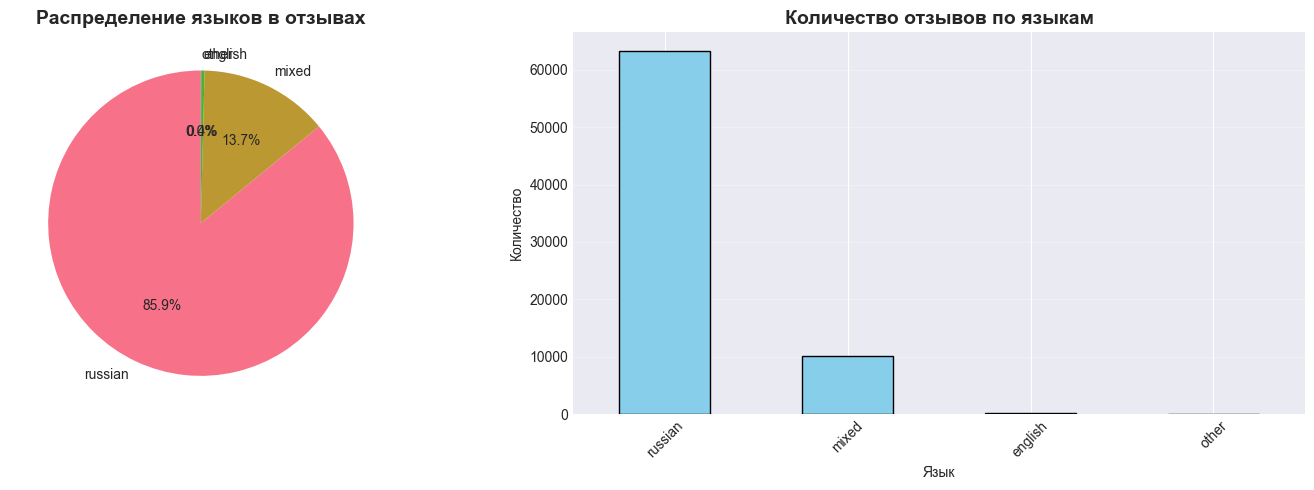

In [9]:
# Визуализация распределения языков
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
lang_stats.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Распределение языков в отзывах', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# Bar chart
lang_stats.plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Количество отзывов по языкам', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Язык')
axes[1].set_ylabel('Количество')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Примеры отзывов по языкам
print("\nПримеры отзывов по языкам:\n")

for lang in ['russian', 'kazakh', 'mixed']:
    if lang in reviews['language'].values:
        print(f"\n--- {lang.upper()} ---")
        examples = reviews[reviews['language'] == lang][TEXT_COL].head(3)
        for i, text in enumerate(examples, 1):
            print(f"{i}. {text[:100]}...")


Примеры отзывов по языкам:


--- RUSSIAN ---
1. Уже который раз заказываем. То еду не довезут. То совсем другое блюдо вместо заказанного. Впечатлени...
2. Официант парень очень медлительный, помимо нас людей не было но он был слишком медленный. Попросили ...
3. Оч вкусно, цены хорошие, заходите...

--- MIXED ---
1. Өте нашар сервис! Отырғанымызға 40 минут болды әлі алған жоқ заказ 3 рет айтылды официантка елемейді...
2. Сүйек сорпасы денеге күш берді, күздің суығында таптырмас ас екен ☕...
3. Сақтар таңғы асы тойымды болды, бір табақпен күні бойы тоқ жүресің 👍...


### 3. Анализ спецсимволов и знаков препинания

In [11]:
print("=" * 80)
print("АНАЛИЗ СПЕЦСИМВОЛОВ")
print("=" * 80)

# Переносы строк
has_newline = reviews[TEXT_COL].fillna('').str.contains('\n', na=False)
print(f"\nОтзывов с переносами строк: {has_newline.sum():,} ({has_newline.sum()/len(reviews)*100:.2f}%)")

# Табуляции
has_tab = reviews[TEXT_COL].fillna('').str.contains('\t', na=False)
print(f"Отзывов с табуляциями: {has_tab.sum():,}")

# URL и ссылки
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
has_url = reviews[TEXT_COL].fillna('').str.contains(url_pattern, na=False, regex=True)
print(f"Отзывов с URL: {has_url.sum():,}")

# Email
email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
has_email = reviews[TEXT_COL].fillna('').str.contains(email_pattern, na=False, regex=True)
print(f"Отзывов с email: {has_email.sum():,}")

# Телефоны
phone_pattern = r'\+?\d[\d\s\-\(\)]{7,}\d'
has_phone = reviews[TEXT_COL].fillna('').str.contains(phone_pattern, na=False, regex=True)
print(f"Отзывов с телефонами: {has_phone.sum():,}")

# Множественные знаки препинания
mult_punct = reviews[TEXT_COL].fillna('').str.contains(r'[!?]{2,}|[.]{3,}', na=False, regex=True)
print(f"Отзывов с множественными знаками: {mult_punct.sum():,}")

АНАЛИЗ СПЕЦСИМВОЛОВ

Отзывов с переносами строк: 12,604 (17.09%)
Отзывов с табуляциями: 6
Отзывов с URL: 7
Отзывов с email: 2
Отзывов с телефонами: 72
Отзывов с множественными знаками: 4,497


## 📊 Базовая статистика

In [12]:
# Длина текстов
reviews['text_length'] = reviews[TEXT_COL].fillna('').str.len()

print("Статистика длины отзывов:")
print(reviews['text_length'].describe())

# Количество слов
reviews['word_count'] = reviews[TEXT_COL].fillna('').str.split().str.len()

print("\nСтатистика количества слов:")
print(reviews['word_count'].describe())

Статистика длины отзывов:
count    73767.000000
mean       151.570160
std        163.945522
min         30.000000
25%         61.000000
50%        103.000000
75%        177.000000
max       2172.000000
Name: text_length, dtype: float64

Статистика количества слов:
count    73767.000000
mean        22.418317
std         25.705194
min          1.000000
25%          9.000000
50%         15.000000
75%         26.000000
max        349.000000
Name: word_count, dtype: float64


## 🧹 Функции очистки данных

In [13]:
def clean_text_basic(text, keep_emoji=True):
    """
    Базовая очистка текста
    
    Args:
        text: Текст для очистки
        keep_emoji: Сохранять эмодзи (True) или удалять (False)
    
    Returns:
        str: Очищенный текст
    """
    if pd.isna(text):
        return ''
    
    text = str(text)
    
    # Удаление URL
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    
    # Удаление email
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)
    
    # Удаление телефонов
    text = re.sub(r'\+?\d[\d\s\-\(\)]{7,}\d', '', text)
    
    # Замена переносов строк на пробелы
    text = text.replace('\n', ' ').replace('\t', ' ')
    
    # Удаление эмодзи (если нужно)
    if not keep_emoji:
        text = emoji_pattern.sub('', text)
    
    # Замена множественных знаков препинания
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)
    
    # Удаление повторяющихся символов (более 3 подряд)
    text = re.sub(r'(.)\1{3,}', r'\1\1', text)
    
    # Удаление лишних пробелов
    text = ' '.join(text.split())
    
    return text.strip()


def clean_text_advanced(text, keep_emoji=True, remove_stopwords=False, stopwords=None):
    """
    Продвинутая очистка с опциональным удалением стоп-слов
    """
    # Базовая очистка
    text = clean_text_basic(text, keep_emoji=keep_emoji)
    
    # Удаление стоп-слов (если нужно)
    if remove_stopwords and stopwords:
        words = text.split()
        words = [w for w in words if w.lower() not in stopwords]
        text = ' '.join(words)
    
    return text


print("✅ Функции очистки созданы")

# Тест
test_text = """Отличное место!!! 😊😊😊
Очень вкусно.... Рекомендую!!!
Телефон: +7 777 123-45-67
Сайт: www.example.com"""

print("\nТест очистки:")
print(f"\nОригинал:\n{test_text}")
print(f"\nС эмодзи:\n{clean_text_basic(test_text, keep_emoji=True)}")
print(f"\nБез эмодзи:\n{clean_text_basic(test_text, keep_emoji=False)}")

✅ Функции очистки созданы

Тест очистки:

Оригинал:
Отличное место!!! 😊😊😊
Очень вкусно.... Рекомендую!!!
Телефон: +7 777 123-45-67
Сайт: www.example.com

С эмодзи:
Отличное место! 😊😊😊 Очень вкусно... Рекомендую! Телефон: Сайт:

Без эмодзи:
Отличное место! Очень вкусно... Рекомендую! Телефон: Сайт:


## 🔤 Частотный анализ и создание стоп-слов

### 1. Токенизация и частотный анализ

In [14]:
from collections import Counter
import string

def tokenize_text(text):
    """
    Простая токенизация текста
    """
    if pd.isna(text):
        return []
    
    text = str(text).lower()
    
    # Удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Разбиение на слова
    tokens = text.split()
    
    # Фильтрация коротких токенов
    tokens = [t for t in tokens if len(t) > 1]
    
    return tokens

print("⏳ Токенизация всех отзывов (может занять время)...")

# Токенизация
all_tokens = []
for text in reviews[TEXT_COL]:
    tokens = tokenize_text(text)
    all_tokens.extend(tokens)

print(f"\n✅ Всего токенов: {len(all_tokens):,}")
print(f"   Уникальных токенов: {len(set(all_tokens)):,}")

⏳ Токенизация всех отзывов (может занять время)...

✅ Всего токенов: 1,483,423
   Уникальных токенов: 107,641


In [15]:
# Частотный анализ
token_counter = Counter(all_tokens)
top_100 = token_counter.most_common(100)

print("Топ-100 самых частых слов:\n")
print(f"{'№':<5} {'Слово':<20} {'Частота':<12}")
print("=" * 40)

for i, (word, count) in enumerate(top_100, 1):
    print(f"{i:<5} {word:<20} {count:<12,}")

Топ-100 самых частых слов:

№     Слово                Частота     
1     очень                37,380      
2     не                   29,540      
3     на                   21,088      
4     все                  16,250      
5     обслуживание         14,588      
6     спасибо              13,401      
7     вкусно               13,215      
8     что                  13,002      
9     за                   12,543      
10    но                   8,923       
11    было                 8,138       
12    это                  7,646       
13    как                  7,036       
14    место                6,998       
15    персонал             6,564       
16    заведение            6,560       
17    вкусная              6,381       
18    по                   6,157       
19    просто               6,092       
20    өте                  5,867       
21    всегда               5,694       
22    вкусные              5,689       
23    официант             5,679       
24    так   

### 2. Выделение казахских слов

In [16]:
# Фильтрация казахских токенов
kazakh_tokens = [token for token in all_tokens if is_kazakh_word(token)]

print(f"Казахских токенов: {len(kazakh_tokens):,}")
print(f"Уникальных: {len(set(kazakh_tokens)):,}")

# Частотный анализ казахских слов
kazakh_counter = Counter(kazakh_tokens)
top_50_kz = kazakh_counter.most_common(50)

print("\nТоп-50 казахских слов:\n")
print(f"{'№':<5} {'Слово':<20} {'Частота':<12}")
print("=" * 40)

for i, (word, count) in enumerate(top_50_kz, 1):
    print(f"{i:<5} {word:<20} {count:<12,}")

Казахских токенов: 77,312
Уникальных: 12,313

Топ-50 казахских слов:

№     Слово                Частота     
1     өте                  5,867       
2     дәмді                3,553       
3     қызмет               2,237       
4     жақсы                2,198       
5     ұнады                1,188       
6     бәрі                 1,000       
7     тамақтары            989         
8     көп                  970         
9     күшті                857         
10    жоғары               670         
11    және                 654         
12    көрсету              638         
13    әрі                  619         
14    рақмет               593         
15    барлығы              585         
16    үлкен                571         
17    көрсетті             537         
18    қыз                  516         
19    қатты                484         
20    деңгейде             452         
21    бізге                415         
22    тағамдары            411         
23    әдем

### 3. Создание кастомного списка стоп-слов

## 🧹 Применение очистки к данным

### Вариант 1: С сохранением эмодзи

In [17]:
print("🧹 Очистка данных (с сохранением эмодзи)...\n")

reviews_clean = reviews.copy()

# Применяем базовую очистку
reviews_clean['text_clean'] = reviews_clean[TEXT_COL].apply(
    lambda x: clean_text_basic(x, keep_emoji=True)
)

# Обновляем метрики
reviews_clean['text_length_clean'] = reviews_clean['text_clean'].str.len()
reviews_clean['word_count_clean'] = reviews_clean['text_clean'].str.split().str.len()

print("✅ Очистка завершена")
print(f"\nСредняя длина до: {reviews['text_length'].mean():.1f}")
print(f"Средняя длина после: {reviews_clean['text_length_clean'].mean():.1f}")

🧹 Очистка данных (с сохранением эмодзи)...

✅ Очистка завершена

Средняя длина до: 151.6
Средняя длина после: 151.1


In [18]:
# Сравнение примеров
print("Примеры очистки:\n")

for i in range(5):
    print(f"\n--- Пример {i+1} ---")
    print(f"ДО:  {reviews[TEXT_COL].iloc[i][:150]}")
    print(f"ПОСЛЕ: {reviews_clean['text_clean'].iloc[i][:150]}")

Примеры очистки:


--- Пример 1 ---
ДО:  Өте нашар сервис! Отырғанымызға 40 минут болды әлі алған жоқ заказ 3 рет айтылды официантка елемейді сөзді, бізден кейін келген адамдардан заказ алып 
ПОСЛЕ: Өте нашар сервис! Отырғанымызға 40 минут болды әлі алған жоқ заказ 3 рет айтылды официантка елемейді сөзді, бізден кейін келген адамдардан заказ алып 

--- Пример 2 ---
ДО:  Уже который раз заказываем. То еду не довезут. То совсем другое блюдо вместо заказанного. Впечатления максимально портите.
ПОСЛЕ: Уже который раз заказываем. То еду не довезут. То совсем другое блюдо вместо заказанного. Впечатления максимально портите.

--- Пример 3 ---
ДО:  Официант парень очень медлительный, помимо нас людей не было но он был слишком медленный. Попросили с собой контейнеры, но официант сам не положил еду
ПОСЛЕ: Официант парень очень медлительный, помимо нас людей не было но он был слишком медленный. Попросили с собой контейнеры, но официант сам не положил еду

--- Пример 4 ---
ДО:  Оч вкусно, цены хор

### Вариант 2: Без эмодзи (для классического NLP)

In [19]:
# Версия без эмодзи
reviews_clean['text_clean_no_emoji'] = reviews_clean[TEXT_COL].apply(
    lambda x: clean_text_basic(x, keep_emoji=False)
)

print("✅ Создана версия без эмодзи")

✅ Создана версия без эмодзи


## 🚫 Финальная фильтрация

In [20]:
print("🚫 Финальная фильтрация...\n")

initial_count = len(reviews_clean)

# 1. Удаляем дубликаты
reviews_clean = reviews_clean.drop_duplicates(subset=['text_clean'])
print(f"✅ Удалены дубликаты: {initial_count - len(reviews_clean)}")

# 2. Фильтруем по длине
initial_count = len(reviews_clean)
reviews_clean = reviews_clean[
    (reviews_clean['text_length_clean'] >= 10) &
    (reviews_clean['text_length_clean'] <= 5000)
]
print(f"✅ Удалены короткие/длинные: {initial_count - len(reviews_clean)}")

# 3. Удаляем пустые
initial_count = len(reviews_clean)
reviews_clean = reviews_clean[reviews_clean['text_clean'].str.len() > 0]
print(f"✅ Удалены пустые: {initial_count - len(reviews_clean)}")

print(f"\n📊 Итого осталось: {len(reviews_clean):,} отзывов")

🚫 Финальная фильтрация...

✅ Удалены дубликаты: 7494
✅ Удалены короткие/длинные: 9
✅ Удалены пустые: 0

📊 Итого осталось: 66,264 отзывов


In [24]:
reviews_clean

,place_firm_id,place_name,place_category,place_category_search,place_rating,place_address,author,author_reviews_count,rating,text,text_length,date,is_verified,has_emoji,language,word_count,text_clean,text_length_clean,word_count_clean,text_clean_no_emoji
0,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Aizhan Umbetova,6,1,Өте нашар сервис! Отырғанымызға 40 минут болды...,193,2025-10-06,True,False,mixed,30,Өте нашар сервис! Отырғанымызға 40 минут болды...,193,30,Өте нашар сервис! Отырғанымызға 40 минут болды...
1,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Джинлиров Рустам,6,1,Уже который раз заказываем. То еду не довезут....,122,2025-10-06,True,False,russian,17,Уже который раз заказываем. То еду не довезут....,122,17,Уже который раз заказываем. То еду не довезут....
2,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Исмаил Найза,9,1,"Официант парень очень медлительный, помимо нас...",257,2025-10-05,True,False,russian,40,"Официант парень очень медлительный, помимо нас...",257,40,"Официант парень очень медлительный, помимо нас..."
3,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Нурлан,17,5,"Оч вкусно, цены хорошие, заходите",33,2025-10-04,True,False,russian,5,"Оч вкусно, цены хорошие, заходите",33,5,"Оч вкусно, цены хорошие, заходите"
4,70000001089786950,"Bauyrdaq Qazaq Fast-food, кафе",Быстрое питание,кафе,4.8,Не указан,Лидия,2,5,Приятное место. Вкусная еда. Обслуживание на в...,118,2025-10-04,True,False,russian,14,Приятное место. Вкусная еда. Обслуживание на в...,118,14,Приятное место. Вкусная еда. Обслуживание на в...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73762,70000001062418192,"Брецель, пекарня",Пекарни,пекарня,4.4,Не указан,Fem 😱,92,5,"Замечательная пекарня, приветливый персонал, н...",283,2022-09-04,True,True,russian,41,"Замечательная пекарня, приветливый персонал, н...",282,41,"Замечательная пекарня, приветливый персонал, н..."
73763,70000001062418192,"Брецель, пекарня",Пекарни,пекарня,4.4,Не указан,Анна Сидоченко,16,5,"Были у вас сегодня, просто наивкуснейшие багет...",170,2022-09-01,True,False,russian,28,"Были у вас сегодня, просто наивкуснейшие багет...",168,28,"Были у вас сегодня, просто наивкуснейшие багет..."
73764,70000001062418192,"Брецель, пекарня",Пекарни,пекарня,4.4,Не указан,zhanna bekova,10,5,"Супер пекарня, очень вкусная выпечка, всегда с...",223,2022-08-31,True,True,russian,30,"Супер пекарня, очень вкусная выпечка, всегда с...",223,30,"Супер пекарня, очень вкусная выпечка, всегда с..."
73765,70000001062418192,"Брецель, пекарня",Пекарни,пекарня,4.4,Не указан,M M,16,2,"Обрадовались, что в доме открыли пекарню. Купи...",373,2022-07-13,True,False,russian,64,"Обрадовались, что в доме открыли пекарню. Купи...",373,64,"Обрадовались, что в доме открыли пекарню. Купи..."


## 📊 Финальная статистика

In [21]:
print("=" * 80)
print("ИТОГОВАЯ СТАТИСТИКА")
print("=" * 80)

print(f"\nИсходное количество: {len(reviews):,}")
print(f"После очистки: {len(reviews_clean):,}")
print(f"Удалено: {len(reviews) - len(reviews_clean):,} ({(len(reviews) - len(reviews_clean))/len(reviews)*100:.2f}%)")

print("\n--- Распределение по языкам (после очистки) ---")
print(reviews_clean['language'].value_counts())

print("\n--- Статистика эмодзи ---")
print(f"С эмодзи: {reviews_clean['has_emoji'].sum():,}")
print(f"Без эмодзи: {(~reviews_clean['has_emoji']).sum():,}")

print("\n--- Средние метрики ---")
print(f"Средняя длина: {reviews_clean['text_length_clean'].mean():.1f} символов")
print(f"Среднее кол-во слов: {reviews_clean['word_count_clean'].mean():.1f}")

ИТОГОВАЯ СТАТИСТИКА

Исходное количество: 73,767
После очистки: 66,264
Удалено: 7,503 (10.17%)

--- Распределение по языкам (после очистки) ---
language
russian    56776
mixed       9244
english      228
other         16
Name: count, dtype: int64

--- Статистика эмодзи ---
С эмодзи: 26,933
Без эмодзи: 39,331

--- Средние метрики ---
Средняя длина: 150.1 символов
Среднее кол-во слов: 22.3


## 💾 Сохранение результатов

In [22]:
# Выбираем колонки для сохранения
columns_to_save = [
    'place_id',
    'text_clean',           # С эмодзи
    'text_clean_no_emoji',  # Без эмодзи
    'rating',
    'language',
    'has_emoji',
    'text_length_clean',
    'word_count_clean'
]

# Добавляем дополнительные колонки если есть
if 'date' in reviews_clean.columns:
    columns_to_save.append('date')
if 'author' in reviews_clean.columns:
    columns_to_save.append('author')

# Фильтруем существующие
columns_to_save = [col for col in columns_to_save if col in reviews_clean.columns]

# Сохраняем
output_file = 'reviews_cleaned_advanced.csv'
reviews_clean[columns_to_save].to_csv(output_file, index=False)

print(f"✅ Данные сохранены в '{output_file}'")
print(f"   Количество отзывов: {len(reviews_clean):,}")
print(f"   Количество колонок: {len(columns_to_save)}")
print(f"\nКолонки:")
for col in columns_to_save:
    print(f"  - {col}")

✅ Данные сохранены в 'reviews_cleaned_advanced.csv'
   Количество отзывов: 66,264
   Количество колонок: 9

Колонки:
  - text_clean
  - text_clean_no_emoji
  - rating
  - language
  - has_emoji
  - text_length_clean
  - word_count_clean
  - date
  - author


## 📈 Визуализация результатов

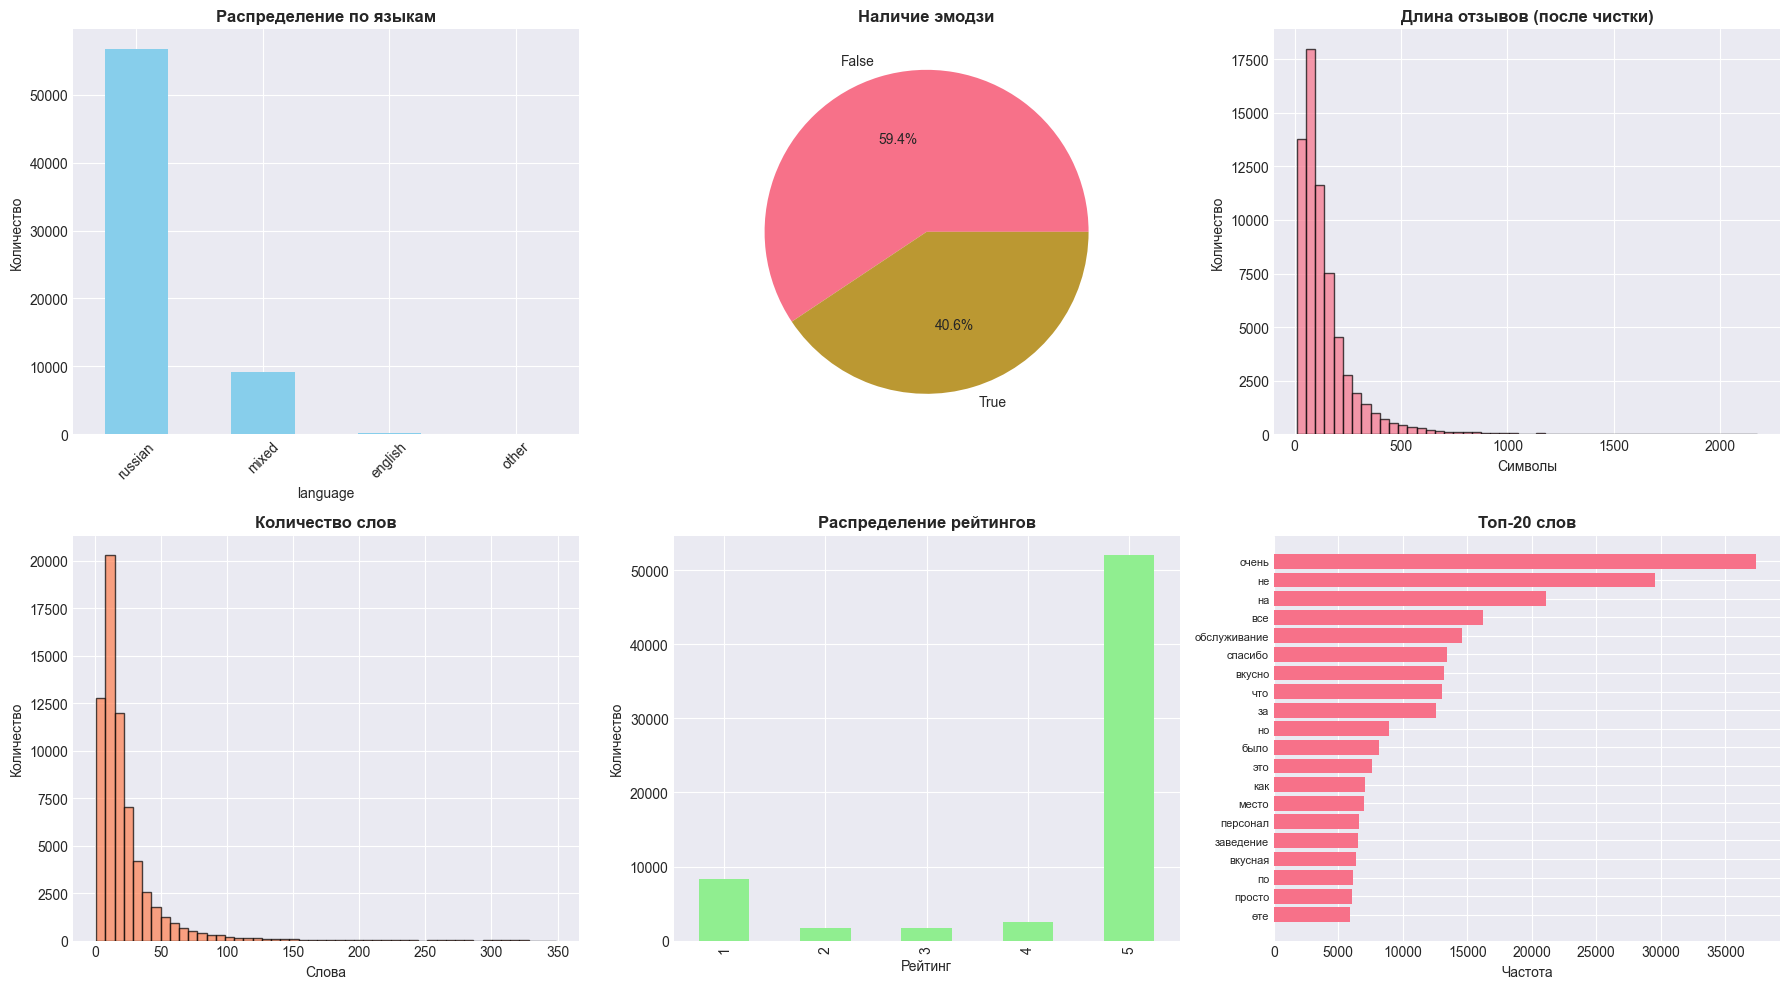

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Распределение языков
reviews_clean['language'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Распределение по языкам', fontweight='bold')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Эмодзи
emoji_data = reviews_clean['has_emoji'].value_counts()
emoji_data.plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%')
axes[0, 1].set_title('Наличие эмодзи', fontweight='bold')
axes[0, 1].set_ylabel('')

# 3. Длина текста
axes[0, 2].hist(reviews_clean['text_length_clean'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Длина отзывов (после чистки)', fontweight='bold')
axes[0, 2].set_xlabel('Символы')
axes[0, 2].set_ylabel('Количество')

# 4. Количество слов
axes[1, 0].hist(reviews_clean['word_count_clean'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_title('Количество слов', fontweight='bold')
axes[1, 0].set_xlabel('Слова')
axes[1, 0].set_ylabel('Количество')

# 5. Рейтинги
if 'rating' in reviews_clean.columns:
    reviews_clean['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title('Распределение рейтингов', fontweight='bold')
    axes[1, 1].set_xlabel('Рейтинг')
    axes[1, 1].set_ylabel('Количество')

# 6. Топ слова
top_20_words = dict(token_counter.most_common(20))
axes[1, 2].barh(range(len(top_20_words)), list(top_20_words.values()))
axes[1, 2].set_yticks(range(len(top_20_words)))
axes[1, 2].set_yticklabels(list(top_20_words.keys()), fontsize=8)
axes[1, 2].set_title('Топ-20 слов', fontweight='bold')
axes[1, 2].set_xlabel('Частота')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

## ✅ Резюме

### Что было сделано:

✅ Анализ эмодзи в отзывах  
✅ Определение языка (русский/казахский/mixed)  
✅ Выявление спецсимволов (URL, email, телефоны)  
✅ Частотный анализ токенов  
✅ Создание кастомных стоп-слов для RU/KZ  
✅ Базовая очистка текста  
✅ Две версии: с эмодзи и без  
✅ Сохранение в `reviews_cleaned_advanced.csv`  

### Следующие шаги:

1. Использовать `reviews_cleaned_advanced.csv` для семантического поиска
2. Выбрать версию текста:
   - `text_clean` - с эмодзи (для sentence-transformers)
   - `text_clean_no_emoji` - без эмодзи (для классического NLP)
3. Запустить `02_semantic_search.ipynb`